# **Fake And Real News Classification**

---

Authors: [Femi Kamau](https://www.github.com/ctrl-Karugu), [Monicah Iwagit](), [Teofilo Gafna](), [Wendy Mwiti](https://www.github.com/WendyMwiti)

## 1. Business Understanding

## 2. Data Understanding

Load Libraries

In [76]:
# Data Manipulation
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
from nltk.collocations import *
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pickle

Load Data

In [77]:
# Load the real news data
real = pd.read_csv('./data/True.csv')

# Load the fake news data
fake = pd.read_csv('./data/Fake.csv')

In [78]:
# Preview real data
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [79]:
# Preview the fake data
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [80]:
#  Add a column called 'category' to both DataFrames which will become our taget variable
real['category'] = 1
fake['category'] = 0

In [81]:
# Combine both DataFrames 
data = pd.concat([real, fake])

In [82]:
# Preview the new DataFrame
print(data.head(5))
print(data.tail(5))

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1  
                                      

In [83]:
class dataUnderstanding(object):
    """A class that does basic Data Understanding"""
    
    def __init__(self, df):
        self.shape = df.shape
        self.info = df.info
        self.duplicates = df.duplicated().sum()
        self.missing = df.isna().sum()
        self.types = df.dtypes

In [84]:
# Instantiate the class
understanding = dataUnderstanding(data)

In [85]:
# Summary of the dataset
print(f"Shape:{understanding.shape}")
print()
print(understanding.info())

Shape:(44898, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB
None


From the summary above, we can see that the dataset contain 44898 rows and spans 5 columns. The columns are: title, text, subject, date and category. The category column is the target variable and the rest are the features.

Furthermore, the dataset contains 4 object columns and 1 integer column. The object columns are: title, text, subject and date. The integer column is: category (target variable). We may need to convert the date column to datetime format in the data preparation phase.

The dataset does not contain any missing values.

In [86]:
# Check for duplicates
print(f"Duplicates: {understanding.duplicates}")

Duplicates: 209


The dataset contains 209 duplicates. They shall be inspected and removed if necessary in the data preparation phase.

In [87]:
# Check the number of missing values
understanding.missing

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [88]:
# Inspect the value counts in the subject column
data['category'].value_counts()

0    23481
1    21417
Name: category, dtype: int64

The articles that are within this dataset fall under 8 different subjects. These are: politicsNews, worldnews, News, politics, left-news, Government News, US_News, and Middle-east.

In [89]:
# Inspect the value counts in the category column
data['category'].value_counts()

0    23481
1    21417
Name: category, dtype: int64

The dataset is fairly balanced between fake and real news 

In [90]:
# Inspect the date column
data['date'].nunique()

2397

The date column contains 2397 unique dates

## 3. Data Preparation


### 3.1 Validity

> To ensure validity within the dataset, we will be checking that the data is in the correct format.

In [91]:
# Converting the subject column to category
data['subject'] = data['subject'].astype('category')

In [92]:
# Converting date from object to datetime
data['date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')

# Type of the date column
data['date'].dtype

# Preview the updated DataFrame 
data.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [93]:
# Extract the months and the years from the date column
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.strftime('%B')

In [94]:
# Inspect the updated datatypes
data.dtypes

title               object
text                object
subject           category
date        datetime64[ns]
category             int64
year               float64
month               object
dtype: object

### 3.2 Consistency

> In this section, we will be obeserving the consistency of the data. We will be checking for duplicates

In [95]:
# Create a dataframe for the duplicated to be inspected
duplicates  = data[data.duplicated()]
duplicates

,title,text,subject,date,category,year,month
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,2017-11-30,1,2017.0,November
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,2017-11-08,1,2017.0,November
892,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,2017-11-02,1,2017.0,November
896,Trump taps Fed centrist Powell to lead U.S. ce...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,2017-11-02,1,2017.0,November
974,"Two ex-Trump aides charged in Russia probe, th...",WASHINGTON (Reuters) - Federal investigators p...,politicsNews,2017-10-30,1,2017.0,October
...,...,...,...,...,...,...,...
21353,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,2017-08-25,1,2017.0,August
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,2017-08-22,1,2017.0,August
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,2017-09-09,0,2017.0,September
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,2017-03-10,0,2017.0,March


In [96]:
# Drop the duplicates
print(f"Before dropping: {len(data)}")
data.drop_duplicates(inplace=True)
print(f"After dropping: {len(data)}")

Before dropping: 44898
After dropping: 44689


Remove the URLS from the text column

### 3.3 Completeness

From data understanding section we found there to be no missing values. Therefore we can confirm that the the dataset is complete.

### 3.4 Uniformity

 To check on whether different systems refer to the same value in the same format

In [97]:
# Check the value counts of the subject column
data['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [98]:
# Rename the categories in the subject column
data['subject'].replace({'politicsNews': 'politics',
                         'worldnews': 'world_news',
                         'News': 'news',
                         'left-news': 'left_news',
                         'Government News': 'government_news',
                         'US_News': 'us_news',
                         'Middle-east': 'middle_east'}, inplace=True)


In [99]:
# Preview the updated subject column value counts
data['subject'].value_counts()

politics           18058
world_news          9991
news                9050
left_news           4459
government_news     1570
us_news              783
middle_east          778
Name: subject, dtype: int64

### 3.5 Exploratory Data Analysis

#### 3.5.1 Univariate Analysis

In [100]:
# Create a function that visualizes the value counts of a column
def plot_bar(df, col)-> None:
    """ A function that returns a plot count of columns"""
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x = col, order=df[col].value_counts().index)
    plt.title(f"{col} count plot")
    plt.ylabel("count")
    plt.xticks(rotation=45)
    plt.show()
    

##### 3.5.1.1 `text`

In [108]:
def plot_word_cloud(df, target, feature, i:int):
    """This fuction creates a wordcloud for the news texts"""
    real_news =df[df[target]==i]
    text = data[feature].values
    wordcloud = WordCloud(
        max_words = 400,
        width = 800,
        height = 600,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (14, 8),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

##### Fake News Visualization Word Cloud

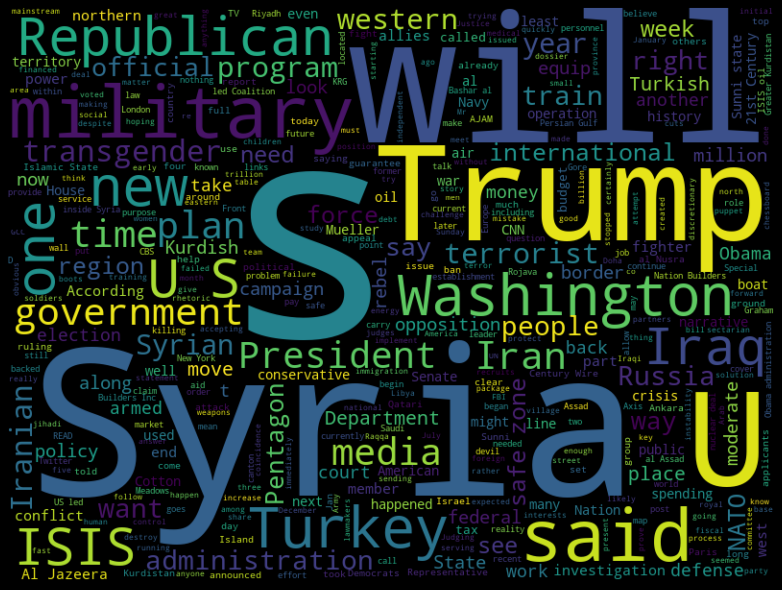

In [109]:
plot_word_cloud(data, 'category', 'text', 0)

##### Real News Visualization Word Cloud

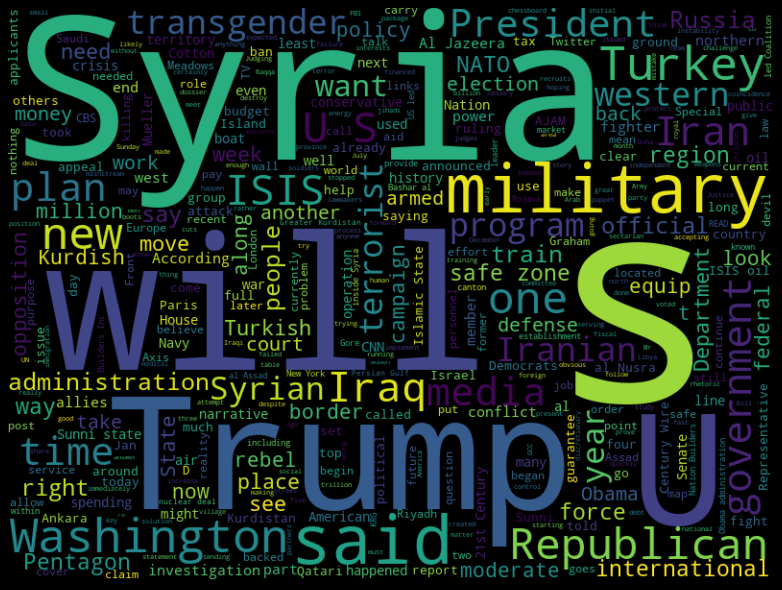

In [110]:
plot_word_cloud(data, 'category', 'text', 1)

##### 3.5.1.2 `subject`

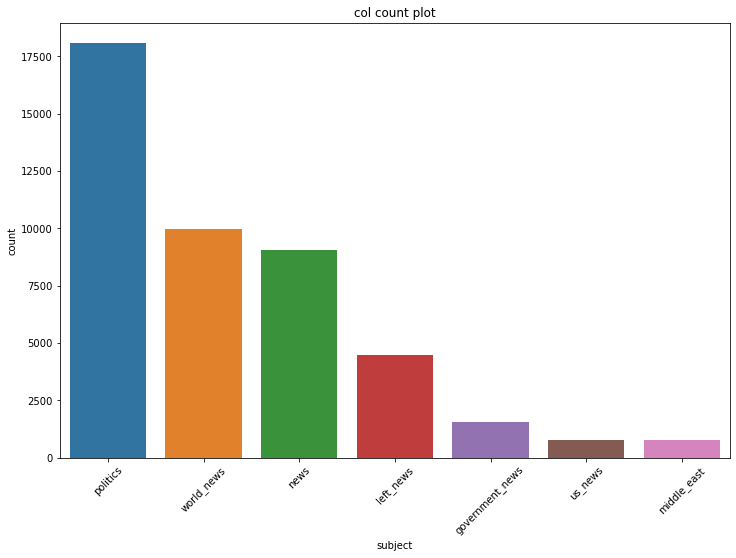

In [104]:
# Plotting a countplot of the subject
plot_bar(data, 'subject')

Observations:
* Most of the published news talk about politics followed by world news while the least discussed subject is the Middle East

##### 3.5.1.3 `month`

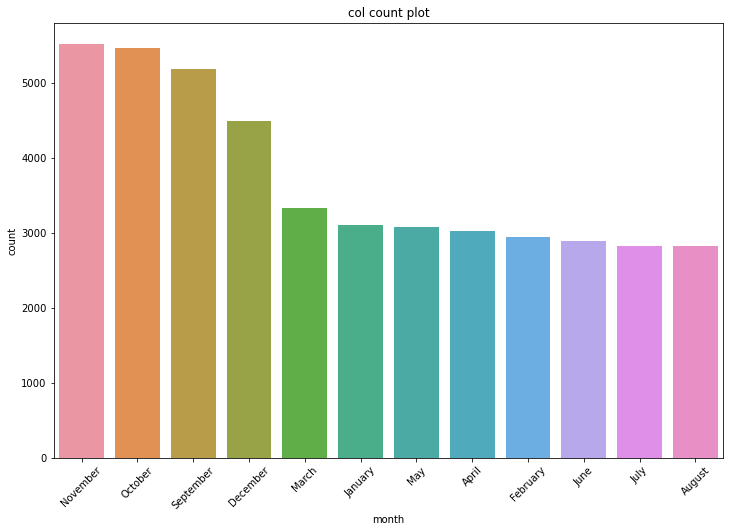

In [105]:
# Plotting a countplot of the Months
plot_bar(data, 'month')

Observations:
* Most of the news is published during the month of November followed by October and September.
* It is also worth noting that the months of September and October precede November.
* The month of August registered the least number of published news

##### 3.5.1.4 `year`

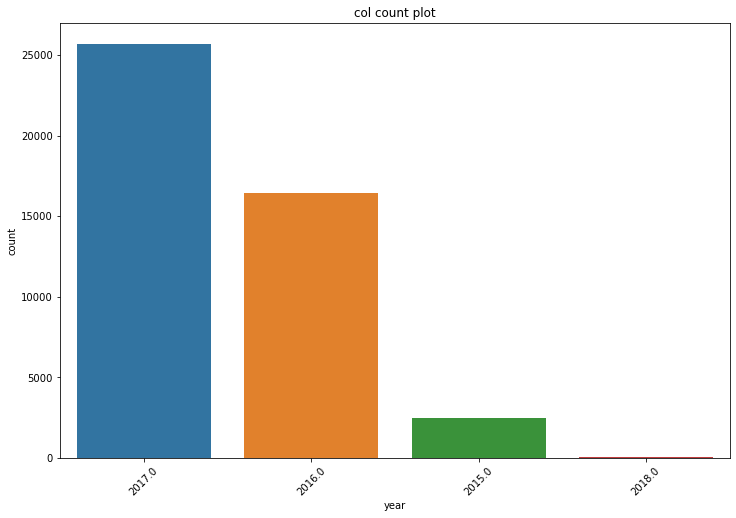

In [106]:
# Plotting the years
plot_bar(data, 'year')

Observations:
* 2017 had the most news followed by 2016

##### 3.5.1.5 `category`

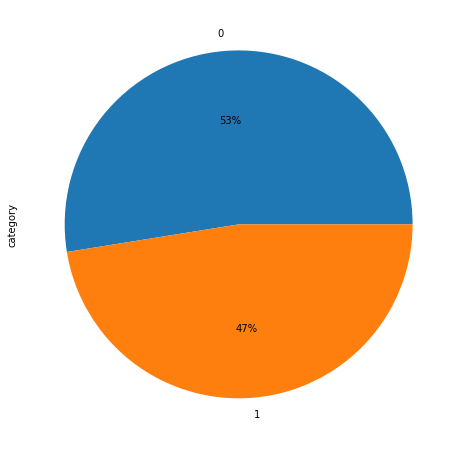

In [111]:
# Plotting a pie chart for the column 'category'
fig, ax = plt.subplots(figsize=(12,8))
data['category'].value_counts().plot(kind='pie', autopct='%.0f%%');

Observations:
* The data set is fairly balanced. However, fake news is slightly more than real news.

#### 3.5.2 Bivariate Analysis

In [31]:
# Creating a function that plots a count plot with respect to another column
def plot_bivariate(df, col, by):
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x=col, hue=by)
    plt.title(f"{col} count plot by {by}")
    plt.ylabel("count")
    plt.xticks(rotation=45)
    plt.show()

##### 3.5.2.1 `month` & `category`

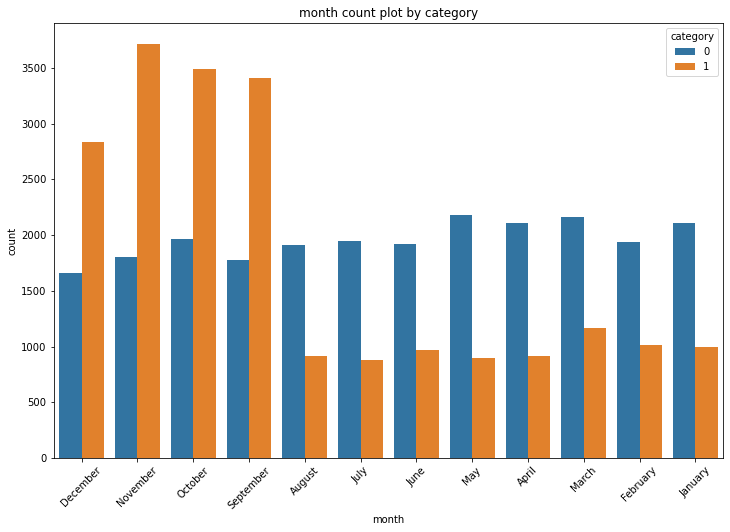

In [32]:
# Plotting month by category
plot_bivariate(data, 'month', 'category')

Observations:
* 

##### 3.5.2.2 `year` & `category`

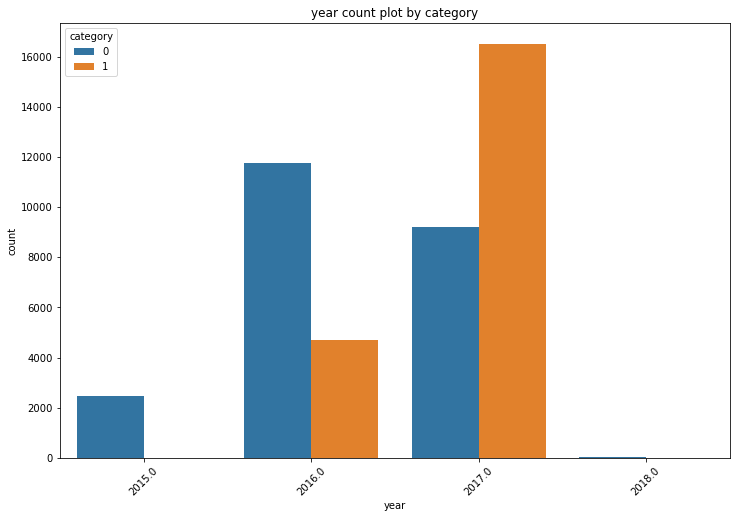

In [33]:
# plot year by category
plot_bivariate(data, 'year', 'category')

Observations:
* 

##### 3.5.2.3 `subject` & `category`

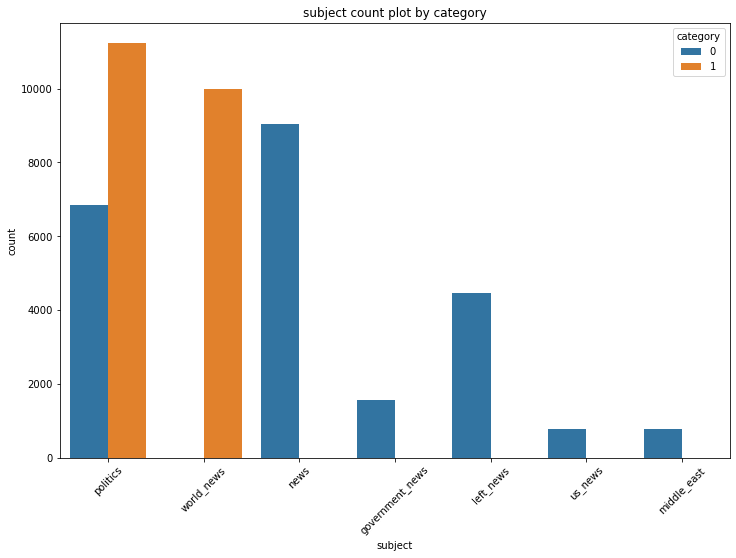

In [34]:
plot_bivariate(data, 'subject', 'category')

## 4. Modeling

### 4.1 Data Preprocessing

In [35]:
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)

True

#### 4.1.1 Lemmatization, Removal of Stopwords & Punctuation

In [59]:
import re
import string
stopwords = nltk.corpus.stopwords.words('english')
lemma = WordNetLemmatizer()
stopwords = set(stopwords)

# Cleaning the Text from Punctuations and Stopwords
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [lemma.lemmatize(word) for word in tokens if word not in stopwords]
    return text

#### 4.1.2 Splitting the dataset

In [37]:
X = data['text']
y = data['category']

# Split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
type(X_train)

pandas.core.series.Series

#### 4.1.3 Vectorization of the Corpus 

In [38]:
# Declaring a Vectoriser
tfidf_vect = TfidfVectorizer(analyzer=clean_text)

# 'Fitting' the Vectoriser
tfidf_vect_fit = tfidf_vect.fit(X_train)

# Creating 'Test' and 'Train' vectorised dataframes
tfidf_train = tfidf_vect_fit.transform(X_train)
tfidf_test = tfidf_vect_fit.transform(X_test)

# Checking, if we did everything alright
tfidf_train

<31282x180911 sparse matrix of type '<class 'numpy.float64'>'
	with 5051878 stored elements in Compressed Sparse Row format>

### 4.2 Train Models

In [39]:
# Getting the scores for various models
def score_model(model, y_test_true, X_test):
    """ A function that returns scores of a model as well as a confusion matrix"""
    
    y_pred = model.predict(X_test)
    
    precision, recall, fscore, train_support = score(y_test_true, y_pred, pos_label=1, average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(accuracy_score(y_test_true,y_pred), 3)))
    
    # Create a confusion matrix 
    cm = confusion_matrix(y_test_true, y_pred)

    # Make a Dataframe, of the metrics with classes
    class_label = [0, 1]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)

    # Plot the Model
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

#### 4.2.1 SVM - Support Vector Machine 

Precision: 0.992 / Recall: 0.993 / F1-Score: 0.992 / Accuracy: 0.993


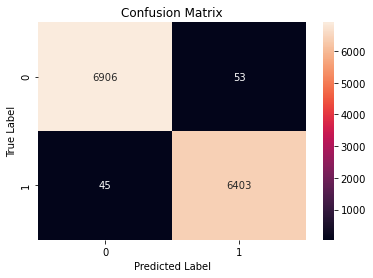

In [40]:
# Instantiate the Support Vector Machine Algorithm
SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')

# Fit algorithm
SVM.fit(tfidf_train, y_train)

score_model(SVM, y_test, tfidf_test)

#### 4.2.2 Logistic Regression

Precision: 0.984 / Recall: 0.984 / F1-Score: 0.984 / Accuracy: 0.985


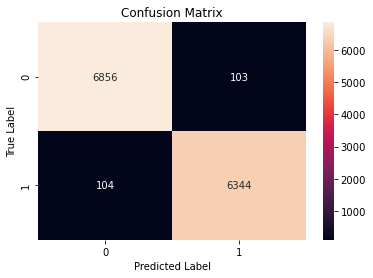

In [41]:
# Instantiate the Logistic Regression Algorithm  
lr = LogisticRegression()

# Fit Algorithm
lr.fit(tfidf_train, y_train)

score_model(lr, y_test, tfidf_test)

#### 4.2.3 Random Forest Algorithm

Precision: 0.977 / Recall: 0.974 / F1-Score: 0.976 / Accuracy: 0.977


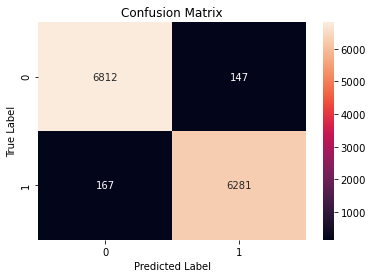

In [42]:
# Instantiate the Naive Bayes Algorithm# 
rf = RandomForestClassifier(min_samples_leaf=20, min_samples_split=20, random_state=100)

# Fit Algorithm
rf = rf.fit(tfidf_train , y_train)

score_model(rf, y_test, tfidf_test)

### 5. Evaluation

### 6. Deployment

In [63]:
# Create a pipeline
pipe = Pipeline([('tfidf', TfidfVectorizer(analyzer=clean_text)),
                 ('lr', LogisticRegression())])

pipe.fit(X_train, y_train)

pipe.predict(X_test)

array([0])

In [65]:
# Pickle the pipeline
pickle.dump(pipe, open('./models/model.pkl', 'wb'))